In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
import glob
import time
from tqdm import tqdm
import os
import json
from lvm_prediction import predict
import pingouin as pg
import scipy.stats
import seaborn as sns

## Violin plot

In [3]:
df_list = []
num_resources_dict = {5:50, 6:250}
for version in [5, 6, 7]:
    for i in tqdm(range(1, 11)):
        # Read the JSON files
        df_cg_i = pd.read_json(f'Data/in_silico_v{version}_results/in_silico_cg/cg_{i}.json', lines=True)  
        df_cg_null_i = pd.read_json(f'Data/in_silico_v{version}_results/in_silico_cg_null/cg_null_{i}.json', lines=True)    
        df_cg_i['num_niches'] = i
        df_cg_i['version'] = version
        df_final_i = pd.merge(df_cg_null_i, df_cg_i, on='label')
        
        df_dist = pd.read_json(f'in_silico_replicates_v{version}/in_silico_replicates_{i}.json', lines=True)[['label', 'best_dist']]
        
        df_final_i = pd.merge(df_final_i, df_dist, on='label')
        
        df_list.append(df_final_i)

100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


In [4]:
df = pd.concat(df_list)
df['NicheDim'] = 1/df['exp_cg']
df['NicheDim_null'] = 1/df['exp_cg_null']
df = df.drop(columns=['exp_cg', 'exp_cg_null'])
df = df[df['best_dist']<=0.3]
print(df.head())

         label  num_niches  version  best_dist  NicheDim  NicheDim_null
1  PRJNA530790           1        5   0.298350  9.031829      11.042499
2   PRJEB27662           1        5   0.254312  8.225844       9.137838
3   PRJEB27564           1        5   0.154522  9.369364      14.411078
4  PRJNA674420           1        5   0.222883  9.515750      13.133137
8  PRJNA625750           1        5   0.235041  7.436340       8.044348


In [5]:
df_5 = df[df['version']==5]
df_6 = df[df['version']==6]
df_7 = df[df['version']==7]

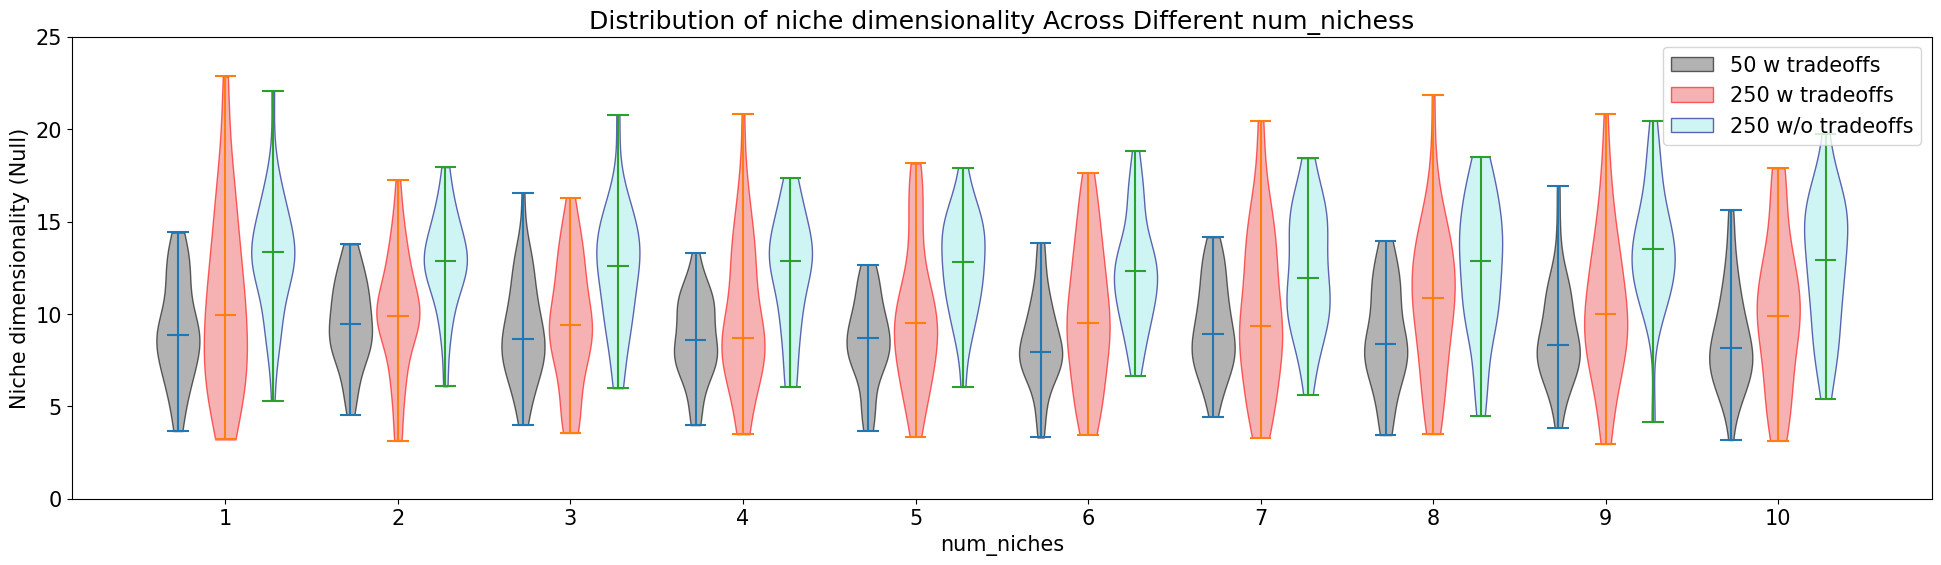

In [9]:
# Group exp_cg values by unique num_nichess
num_nichess = np.arange(1,11,1)
data_5_null = [df_5[df_5['num_niches'] == num_niches]['NicheDim_null'].values for num_niches in num_nichess]
data_6_null = [df_6[df_6['num_niches'] == num_niches]['NicheDim_null'].values for num_niches in num_nichess]
data_7_null = [df_7[df_7['num_niches'] == num_niches]['NicheDim_null'].values for num_niches in num_nichess]

data_5_null = [x[~np.isnan(x)] for x in data_5_null]
data_6_null = [x[~np.isnan(x)] for x in data_6_null]
data_7_null = [x[~np.isnan(x)] for x in data_7_null]

# Create the violin plot
fig, ax = plt.subplots(figsize=(24, 6))
violin_plot_5 = ax.violinplot(data_5_null, positions=np.arange(len(num_nichess))-0.275, showmedians=True, showextrema=True, widths=0.25)
violin_plot_6 = ax.violinplot(data_6_null, positions=np.arange(len(num_nichess)), showmedians=True, showextrema=True, widths=0.25)
violin_plot_7 = ax.violinplot(data_7_null, positions=np.arange(len(num_nichess))+0.275, showmedians=True, showextrema=True, widths=0.25)

handles = [violin_plot_5['bodies'][0], violin_plot_6['bodies'][0], violin_plot_7['bodies'][0]]
labels = ['50 w tradeoffs', '250 w tradeoffs', '250 w/o tradeoffs']

# You can adjust the colors of the violin plots
for pc in violin_plot_5['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(0.6)

for pc in violin_plot_6['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_edgecolor('red')
    pc.set_alpha(0.6)
    
for pc in violin_plot_7['bodies']:
    pc.set_facecolor('paleturquoise')
    pc.set_edgecolor('navy')
    pc.set_alpha(0.6)

# Customize the plot
ax.set_xticks(np.arange(len(num_nichess)))
ax.set_xticklabels(num_nichess)  # Rotate labels for better readability
ax.set_xlabel("num_niches")
ax.set_ylabel("Niche dimensionality (Null)")
ax.set_title("Distribution of niche dimensionality Across Different num_nichess")
plt.ylim([0, 25])
ax.legend(handles, labels)
plt.savefig('Pictures/niche_dim_null_distribution_across_food_groups_and_num_resources.pdf', format='pdf')
plt.show()

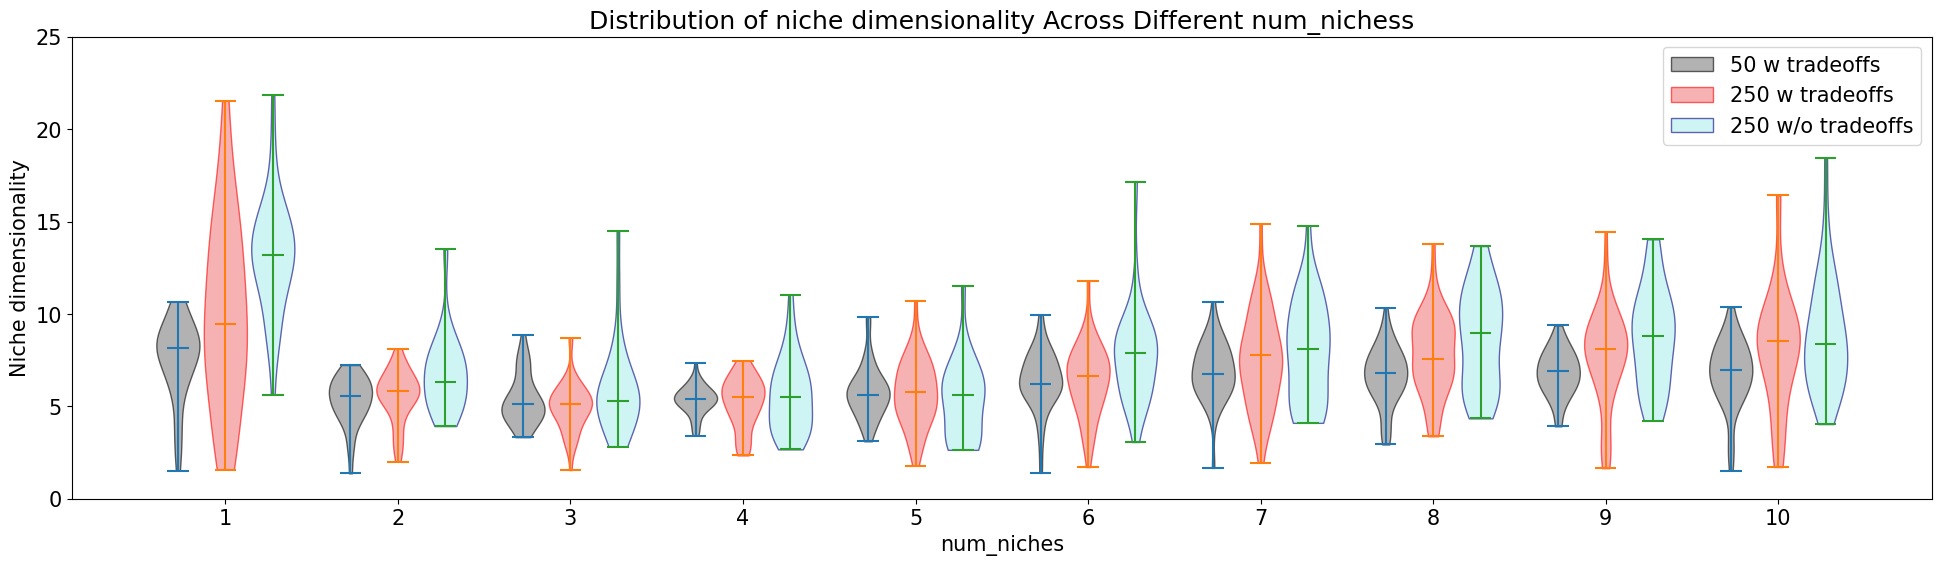

In [ ]:
# Group exp_cg values by unique num_nichess
num_nichess = np.arange(1,11,1)
data_5 = [df_5[df_5['num_niches'] == num_niches]['NicheDim'].values for num_niches in num_nichess]
data_6 = [df_6[df_6['num_niches'] == num_niches]['NicheDim'].values for num_niches in num_nichess]
data_7 = [df_7[df_7['num_niches'] == num_niches]['NicheDim'].values for num_niches in num_nichess]

data_5 = [x[~np.isnan(x)] for x in data_5]
data_6 = [x[~np.isnan(x)] for x in data_6]
data_7 = [x[~np.isnan(x)] for x in data_7]

# Create the violin plot
fig, ax = plt.subplots(figsize=(24, 6))
violin_plot_5 = ax.violinplot(data_5, positions=np.arange(len(num_nichess))-0.275, showmedians=True, showextrema=True, widths=0.25)
violin_plot_6 = ax.violinplot(data_6, positions=np.arange(len(num_nichess)), showmedians=True, showextrema=True, widths=0.25)
violin_plot_7 = ax.violinplot(data_7, positions=np.arange(len(num_nichess))+0.275, showmedians=True, showextrema=True, widths=0.25)

handles = [violin_plot_5['bodies'][0], violin_plot_6['bodies'][0], violin_plot_7['bodies'][0]]
labels = ['50 w tradeoffs', '250 w tradeoffs', '250 w/o tradeoffs']

# You can adjust the colors of the violin plots
for pc in violin_plot_5['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(0.6)

for pc in violin_plot_6['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_edgecolor('red')
    pc.set_alpha(0.6)
    
for pc in violin_plot_7['bodies']:
    pc.set_facecolor('paleturquoise')
    pc.set_edgecolor('navy')
    pc.set_alpha(0.6)

# Customize the plot
ax.set_xticks(np.arange(len(num_nichess)))
ax.set_xticklabels(num_nichess)  # Rotate labels for better readability
ax.set_xlabel("num_niches")
ax.set_ylabel("Niche dimensionality")
ax.set_title("Distribution of niche dimensionality Across Different num_nichess")
plt.ylim([0, 25])
ax.legend(handles, labels)
plt.savefig('Pictures/niche_dim_distribution_across_food_groups_and_num_resources.pdf', format='pdf')
plt.show()

In [7]:
from scipy import stats

# Calculate the KS statistic for each pair of distributions
results = []
for i, num_niches in enumerate(num_nichess):
    dist_5 = data_5[i]
    dist_6 = data_6[i]

    # Check if distributions are non-empty to perform the test
    if len(dist_5) > 0 and len(dist_6) > 0:
        ks_stat, p_value = stats.ks_2samp(dist_5, dist_6)
        results.append({
            'num_niches': num_niches,
            'KS_Statistic': ks_stat,
            'p-value': p_value
        })
    else:
        results.append({
            'num_niches': num_niches,
            'KS_Statistic': None,
            'p-value': None
        })

# Create a DataFrame from the results
ks_df = pd.DataFrame(results)

print("Kolmogorov-Smirnov (KS) Test Results:")
print(ks_df)

Kolmogorov-Smirnov (KS) Test Results:
   num_niches  KS_Statistic   p-value
0           1      0.431818  0.000773
1           2      0.176307  0.528969
2           3      0.146636  0.694794
3           4      0.177945  0.483488
4           5      0.183014  0.436782
5           6      0.170635  0.561947
6           7      0.241026  0.144966
7           8      0.357143  0.008947
8           9      0.395297  0.001837
9          10      0.433198  0.000644


## Mean trend

In [5]:
mb_small = pd.read_csv('checkpoints/mb_small.csv', index_col=0)

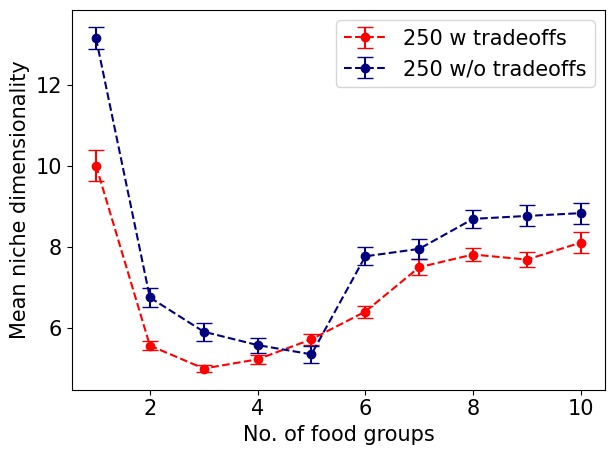

In [9]:
# y_mean = np.mean(mb_small['END'].dropna())
# y_std = np.std(mb_small['END'].dropna())

# plt.fill_between(np.linspace(1, 10, 100), [y_mean + 2*y_std]*100, [y_mean - 2*y_std]*100, alpha=0.3)

# plt.errorbar(np.arange(1, 11, 1), [np.mean(x) for x in data_5], yerr=[stats.sem(x)/2 for x in data_5], capsize=6, marker='o', linestyle='--', color='black', label='50 w tradeoffs')
plt.errorbar(np.arange(1, 11, 1), [np.mean(x) for x in data_6], yerr=[stats.sem(x)/2 for x in data_6], capsize=6, marker='o', linestyle='--', color='red', label='250 w tradeoffs')
plt.errorbar(np.arange(1, 11, 1), [np.mean(x) for x in data_7], yerr=[stats.sem(x)/2 for x in data_7], capsize=6, marker='o', linestyle='--', color='navy', label='250 w/o tradeoffs')
plt.legend()
plt.ylabel('Mean niche dimensionality')
plt.xlabel('No. of food groups')
plt.tight_layout()
plt.savefig('Pictures_for_paper/IS_END_num_food_groups.pdf', format='pdf')
plt.show()

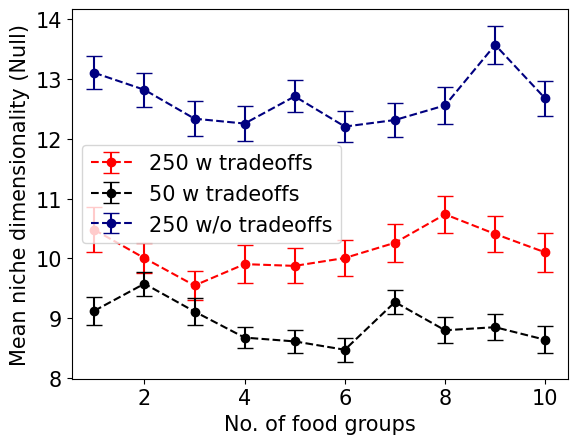

In [33]:
plt.errorbar(np.arange(1, 11, 1), [np.mean(x) for x in data_6_null], yerr=[stats.sem(x)/2 for x in data_6_null], capsize=6, marker='o', linestyle='--', color='red', label='250 w tradeoffs')
plt.errorbar(np.arange(1, 11, 1), [np.mean(x) for x in data_5_null], yerr=[stats.sem(x)/2 for x in data_5_null], capsize=6, marker='o', linestyle='--', color='black', label='50 w tradeoffs')
plt.errorbar(np.arange(1, 11, 1), [np.mean(x) for x in data_7_null], yerr=[stats.sem(x)/2 for x in data_7_null], capsize=6, marker='o', linestyle='--', color='navy', label='250 w/o tradeoffs')
plt.legend()
plt.ylabel('Mean niche dimensionality (Null)')
plt.xlabel('No. of food groups')
plt.show()

## Env dim vs Niche dim trend

In [2]:
# df_5 = pd.read_csv('/home/ks2823/Microbiomap/checkpoints/in_silico_v5.csv', index_col=0).dropna()
df_6 = pd.read_csv('/home/ks2823/Microbiomap/checkpoints/in_silico_v6.csv', index_col=0).dropna()
df_7 = pd.read_csv('/home/ks2823/Microbiomap/checkpoints/in_silico_v7.csv', index_col=0).dropna()

In [3]:
df_6.columns

Index(['label', 'num_niches', 'mean_load', 'var_load', 'load_ratio',
       'mean_resources', 'weighted_pref', 'cosine_similarity', 'taylor',
       'alpha', 'EnvDim', 'EnvDimLog', 'EnvPr', 'EnvPrLog', 'EnvPrCorr',
       'EnvPrLogCorr', 'best_dist', 'num_resources', 'generalists',
       'crm_sparsity', 'mean_num_resources', 'comp', 'exp_cg', 'NicheDim'],
      dtype='object')

In [4]:
# df_50_vanilla = df_5[df_5['num_niches']==1]
df_250_vanilla = df_7[df_7['num_niches']==1]
df_250_bac_trade = df_6[df_6['num_niches']==1]

In [ ]:
# df_50_env_bac_trade = df_5[np.isin(df_5['num_niches'], np.arange(2, 8, 1))]

In [ ]:
# np.median(df_50_env_bac_trade['NicheDim'].values)

5.778645738090251

In [5]:
np.percentile(df_250_bac_trade['NicheDim'].values, [25, 50, 75])

array([ 6.38638527,  9.4519179 , 13.40115295])

In [6]:
import pingouin as pg
from tabulate import tabulate

### Correlations for each no. of complex foods

In [ ]:
df_list = [df_6, df_7]
df_key_list = ['250 tradeoffs', '250 vanilla']

for var, var_key in zip(['alpha', 'comp', 'EnvDimLog'], ['Shannon entropy', 'Niche overlap', 'Environmental complexity']):
    table_data = [['NumNiche', 1, 'p-val', 2, 'p-val', 3, 'p-val', 4, 'p-val', 5, 'p-val', 6, 'p-val', 7, 'p-val', 8, 'p-val', 9, 'p-val', 10, 'p-val']]
    for df, df_key in zip(df_list, df_key_list):
        df_data = [df_key]
        for i in range(1, 11):
            df_i = df[df['num_niches']==i]
            output = pg.partial_corr(df_i, x='NicheDim', y=var, method='spearman')
            spearman, pval = output['r'].values[0], output['p-val'].values[0]
            # if pval > 0.05:
            #     spearman = np.nan
            df_data.append(spearman)
            df_data.append(pval)
        table_data.append(df_data)
    table_data = np.array(table_data)
    print(f'Niche dimensionality vs {var_key}')
    print(tabulate(table_data))

### Sampling from microbiomap probability distribution

In [8]:
def get_num_species(project):
    data = pd.read_csv(f'/home/ks2823/Microbiomap/post_process_projects/{project}.csv', index_col=0)
    return data.shape[1]
cg_file = pd.read_json('/home/ks2823/Microbiomap/Data/MB_100_subsampled_results/cg.json', lines=True)
cg_file['project'] = cg_file['label'].apply(lambda x: x.split('_')[0])
projects_w_100_samples = cg_file['project'].unique()
print(len(projects_w_100_samples))

num_species_dict = {'project': [],
                'num_species': []}
for project in projects_w_100_samples:
    num_species_dict['project'].append(project)
    num_species_dict['num_species'].append(get_num_species(project))

num_species_df = pd.DataFrame(num_species_dict)
projects_w_100_samples_and_70_species = num_species_df[num_species_df['num_species'] >= 70]['project']

m_ncf_df = pd.read_csv('Data/MB_NCF_SuperSimpleModel.csv', index_col=0)
m_ncf_df = m_ncf_df[np.isin(m_ncf_df['project'], projects_w_100_samples_and_70_species)]
print(m_ncf_df.head())
print(len(m_ncf_df))

306
    ncf_ssm     project
2         1  PRJDB10528
4         1  PRJDB11845
5         1  PRJDB11894
8         1   PRJDB5564
11        1   PRJDB6804
201


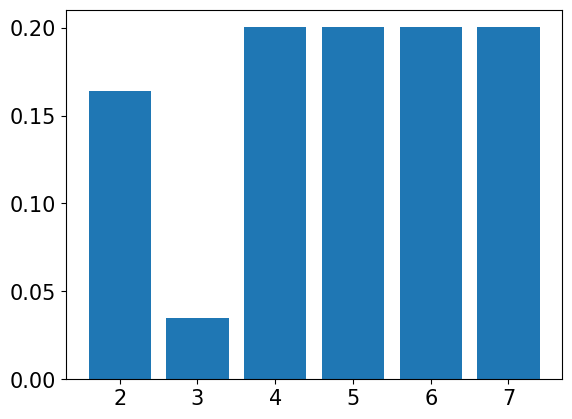

In [9]:
ncf_values, ncf_counts = np.unique(m_ncf_df['ncf_ssm'], return_counts=True)
ncf_probs = ncf_counts/np.sum(ncf_counts)

probabilities = {
    2: ncf_probs[1],
    3: ncf_probs[2],
    4: ncf_probs[0]/4,
    5: ncf_probs[0]/4,
    6: ncf_probs[0]/4,
    7: ncf_probs[0]/4,
}
plt.bar(probabilities.keys(), [probabilities[key] for key in probabilities.keys()])
plt.show()

In [10]:
df_250_env_trade = df_7[np.isin(df_7['num_niches'], np.arange(2, 8, 1))]
df_250_env_bac_trade = df_6[np.isin(df_6['num_niches'], np.arange(2, 8, 1))]

In [11]:
def perform_stratified_sampling(df: pd.DataFrame, strata_col: str, total_samples: int, probabilities: dict) -> pd.DataFrame:
    """
    Performs stratified random sampling on a pandas DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame to sample from.
        strata_col (str): The name of the column to stratify by (e.g., 'num_niches').
        total_samples (int): The total number of samples desired in the final DataFrame.
        probabilities (dict): A dictionary where keys are the unique values in the strata_col
                              and values are their corresponding sampling probabilities.
                              The probabilities must sum to 1.0.

    Returns:
        pd.DataFrame: A new DataFrame containing the stratified sample, with rows shuffled.
                      Returns an empty DataFrame if an error occurs.
    """
    # --- Input Validation ---
    if strata_col not in df.columns:
        print(f"Error: Stratification column '{strata_col}' not found in the DataFrame.")
        return pd.DataFrame()

    if not np.isclose(sum(probabilities.values()), 1.0):
        print(f"Error: Probabilities must sum to 1.0, but they sum to {sum(probabilities.values())}.")
        return pd.DataFrame()

    # --- 1. Calculate the number of samples for each stratum ---
    prob_series = pd.Series(probabilities)
    samples_per_stratum = (total_samples * prob_series).round().astype(int)

    # print("Target number of samples per stratum:")
    # print(samples_per_stratum)
    # print("-" * 30)

    # --- 2. Define a safe sampling function to apply to each group ---
    def safe_sample(group, n):
        """Samples n rows from a group, or all rows if the group is smaller than n."""
        # Use min() to prevent requesting more samples than available in the group
        num_to_sample = min(len(group), n)
        return group.sample(n=num_to_sample, replace=False)

    # --- 3. Apply stratified sampling ---
    # The 'group_keys=False' argument prevents the group label from becoming an index
    stratified_sample = (
        df.groupby(strata_col, group_keys=False)
          .apply(lambda g: safe_sample(g, samples_per_stratum.get(g.name, 0)))
    )

    # --- 4. Shuffle the final result and reset the index ---
    final_df = stratified_sample.sample(frac=1).reset_index(drop=True)

    return final_df

250 env cov NicheDim: [4.94082235 6.34883624 8.31299293]


/tmp/tmp.w2fr5cE6aq/ipykernel_601971/1005345672.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: safe_sample(g, samples_per_stratum.get(g.name, 0)))


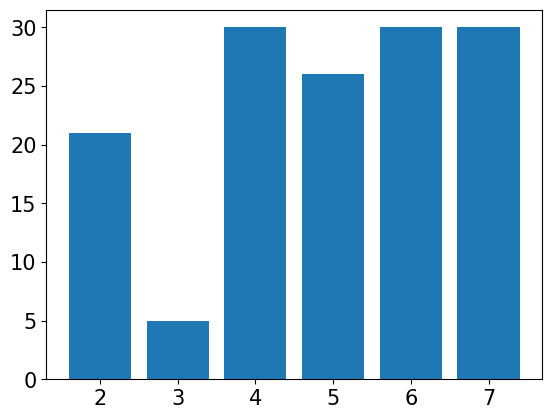

/tmp/tmp.w2fr5cE6aq/ipykernel_601971/1005345672.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: safe_sample(g, samples_per_stratum.get(g.name, 0)))


250 env cov + Tradeoffs NicheDim: [4.96718453 5.95879779 7.17457989]


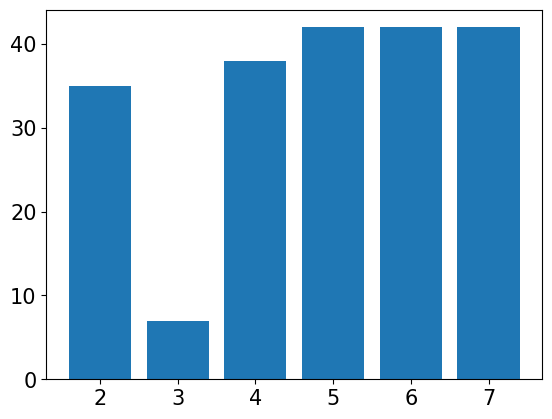

In [13]:
df_250_env_trade = df_7[np.isin(df_7['num_niches'], np.arange(2, 8, 1))]
df_250_env_bac_trade = df_6[np.isin(df_6['num_niches'], np.arange(2, 8, 1))]

num_samples_250_env_trade = len(df_250_env_trade[df_250_env_trade['num_niches']>3])/0.8
df_250_env_trade_stratified = perform_stratified_sampling(
    df=df_250_env_trade,
    strata_col='num_niches',
    total_samples=num_samples_250_env_trade,
    probabilities=probabilities
)

vals, counts = np.unique(df_250_env_trade_stratified['num_niches'], return_counts=True)
stratified_probs = counts/np.sum(counts)
print('250 env cov NicheDim:', np.percentile(df_250_env_trade_stratified['NicheDim'], [25, 50, 75]))

plt.bar(vals, counts)
plt.show()

num_samples_250_env_bac_trade = len(df_250_env_bac_trade[df_250_env_bac_trade['num_niches']>3])/0.8
df_250_env_bac_trade_stratified = perform_stratified_sampling(
    df=df_250_env_bac_trade,
    strata_col='num_niches',
    total_samples=num_samples_250_env_bac_trade,
    probabilities=probabilities
)

vals, counts = np.unique(df_250_env_bac_trade_stratified['num_niches'], return_counts=True)
stratified_probs = counts/np.sum(counts)
print('250 env cov + Tradeoffs NicheDim:', np.percentile(df_250_env_bac_trade_stratified['NicheDim'], [25, 50, 75]))
plt.bar(vals, counts)
plt.show()

### Threshold

In [25]:
df_250_env_trade = df_7[np.isin(df_7['num_niches'], np.arange(2, 11, 1))]
df_250_env_bac_trade = df_6[np.isin(df_6['num_niches'], np.arange(2, 11, 1))]

df_list = [df_250_vanilla, df_250_bac_trade, df_250_env_trade, df_250_env_bac_trade]
df_key_list = ['250 vanilla', '250 tradeoffs', '250 env cov', '250 tradeoffs + env cov']

for threshold in [7, 8, 9, 10]:
    print('#####################################')
    print(f'Threshold: {threshold}')
    print('#####################################')
    for var, var_key in zip(['alpha', 'comp', 'EnvDimLog'], ['Shannon entropy', 'Niche overlap', 'Environmental complexity']):
        table_data = []
        for df, df_key in zip(df_list, df_key_list):
            df = df[df['EnvDimLog']<10]
            try:
                output = pg.partial_corr(df, x='NicheDim', y=var, method='spearman')
                spearman, pval = output['r'].values[0], output['p-val'].values[0]
                table_data.append([df_key, f'{spearman:.2f}'])
                table_data.append(['P-value', f'{pval:.2f}'])
            except:
                table_data.append([df_key, np.nan])
                table_data.append(['P-value', np.nan])
        table_data = np.array(table_data).T
        print(f'Niche dimensionality vs {var_key}')
        print(tabulate(table_data), '\n')

#####################################
Threshold: 7
#####################################
Niche dimensionality vs Shannon entropy
-----------  -------  -------------  -------  -----------  -------  -----------------------  -------
250 vanilla  P-value  250 tradeoffs  P-value  250 env cov  P-value  250 tradeoffs + env cov  P-value
nan          nan      nan            nan      -0.11        0.25     0.37                     0.00
-----------  -------  -------------  -------  -----------  -------  -----------------------  ------- 

Niche dimensionality vs Niche overlap
-----------  -------  -------------  -------  -----------  -------  -----------------------  -------
250 vanilla  P-value  250 tradeoffs  P-value  250 env cov  P-value  250 tradeoffs + env cov  P-value
nan          nan      nan            nan      -0.05        0.63     -0.10                    0.18
-----------  -------  -------------  -------  -----------  -------  -----------------------  ------- 

Niche dimensionality vs Env

In [53]:
np.unique(df_250_env_bac_trade_stratified['num_niches'], return_counts=True)

(array([2, 3, 4, 5, 6, 7]), array([35,  7, 38, 42, 42, 42]))

### 2-7 no. of complex foods

In [6]:
df_250_env_trade = df_7[np.isin(df_7['num_niches'], np.arange(2, 8, 1))]
df_250_env_bac_trade = df_6[np.isin(df_6['num_niches'], np.arange(2, 8, 1))]

df_list = [df_250_vanilla, df_250_bac_trade, df_250_env_trade, df_250_env_bac_trade]
df_key_list = ['250 vanilla', '250 tradeoffs', '250 env cov', '250 tradeoffs + env cov']

for df, df_key in zip(df_list, df_key_list):
    print(df_key, np.percentile(df['NicheDim'], [25, 50, 75]))    

250 vanilla [11.6615201  13.18839086 14.85059976]
250 tradeoffs [ 6.38638527  9.4519179  13.40115295]
250 env cov [4.8781609  6.21648443 8.12769083]
250 tradeoffs + env cov [4.71493277 5.77821905 6.95355514]


In [22]:
sp.stats.mannwhitneyu(df_250_env_trade['NicheDim'], df_250_env_bac_trade['NicheDim'])

MannwhitneyuResult(statistic=25229.0, pvalue=0.017671355532522547)

In [7]:
df_250_env_trade = df_7[np.isin(df_7['num_niches'], np.arange(2,8, 1))]
df_250_env_bac_trade = df_6[np.isin(df_6['num_niches'], np.arange(2,8, 1))]

df_list = [df_250_vanilla, df_250_bac_trade, df_250_env_trade, df_250_env_bac_trade]
df_key_list = ['250 vanilla', '250 tradeoffs', '250 env cov', '250 tradeoffs + env cov']

for var, var_key in zip(['alpha', 'comp', 'EnvDimLog', 'mean_num_resources', 'mean_load'], ['Shannon entropy', 'Niche overlap', 'Environmental complexity', 'Mean no. of resources', 'Total load']):
    table_data = []
    for df, df_key in zip(df_list, df_key_list):
        output = pg.partial_corr(df, x='NicheDim', y=var, method='spearman')
        spearman, pval = output['r'].values[0], output['p-val'].values[0]
        table_data.append([df_key, f'{spearman:.2e}'])
        table_data.append(['P-value', f'{pval:.2e}'])
    table_data = np.array(table_data).T
    print(f'Niche dimensionality vs {var_key}')
    print(tabulate(table_data), '\n')

Niche dimensionality vs Shannon entropy
-----------  --------  -------------  --------  -----------  --------  -----------------------  --------
250 vanilla  P-value   250 tradeoffs  P-value   250 env cov  P-value   250 tradeoffs + env cov  P-value
9.70e-01     1.64e-20  9.74e-01       1.10e-28  -7.88e-02    3.03e-01  4.69e-01                 1.75e-15
-----------  --------  -------------  --------  -----------  --------  -----------------------  -------- 

Niche dimensionality vs Niche overlap
-----------  --------  -------------  --------  -----------  --------  -----------------------  --------
250 vanilla  P-value   250 tradeoffs  P-value   250 env cov  P-value   250 tradeoffs + env cov  P-value
-3.76e-01    3.10e-02  -2.54e-01      9.64e-02  -1.20e-01    1.15e-01  -1.61e-01                9.56e-03
-----------  --------  -------------  --------  -----------  --------  -----------------------  -------- 

Niche dimensionality vs Environmental complexity
-----------  --------  --------

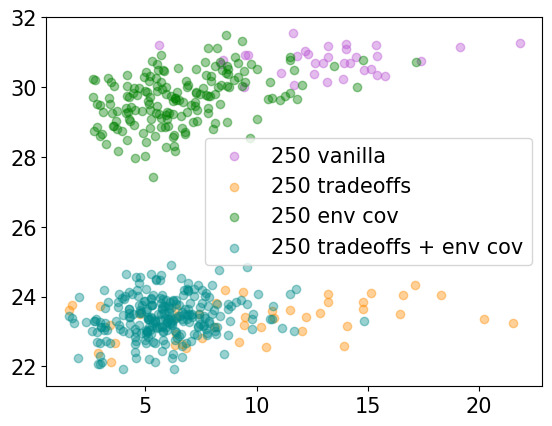

In [30]:
color_list = ['mediumorchid', 'darkorange', 'green', 'darkcyan']
for df, df_key, color in zip(df_list, df_key_list, color_list):
    plt.scatter(df['NicheDim'], df['mean_num_resources'], alpha=0.4, label=df_key, color=color)
plt.legend()
plt.show()

In [ ]:
for i in np.arange(4, 11, 1):
    
    print('###################################')
    print(f'Mixing complex foods 2-{i}')
    print('###################################\n')
    df_250_env_trade = df_7[np.isin(df_7['num_niches'], np.arange(2,i+1, 1))]
    df_250_env_bac_trade = df_6[np.isin(df_6['num_niches'], np.arange(2,i+1, 1))]

    df_list = [df_250_env_trade, df_250_env_bac_trade]
    df_key_list = ['250 env cov', '250 tradeoffs + env cov']

    for var, var_key in zip(['alpha', 'comp', 'EnvDimLog'], ['Shannon entropy', 'Niche overlap', 'Environmental complexity']):
        table_data = []
        for df, df_key in zip(df_list, df_key_list):
            output = pg.partial_corr(df, x='NicheDim', y=var, method='spearman')
            spearman, pval = output['r'].values[0], output['p-val'].values[0]
            table_data.append([df_key, f'{spearman:.2f}'])
            table_data.append(['P-value', f'{pval:.2f}'])
        table_data = np.array(table_data).T
        print(f'Niche dimensionality vs {var_key}')
        print(tabulate(table_data), '\n')

###################################
Mixing complex foods 2-4
###################################

Niche dimensionality vs Shannon entropy
-----------  -------  -----------------------  -------
250 env cov  P-value  250 tradeoffs + env cov  P-value
-0.01        0.91     0.33                     0.00
-----------  -------  -----------------------  ------- 

Niche dimensionality vs Niche overlap
-----------  -------  -----------------------  -------
250 env cov  P-value  250 tradeoffs + env cov  P-value
-0.11        0.31     -0.08                    0.39
-----------  -------  -----------------------  ------- 

Niche dimensionality vs Environmental complexity
-----------  -------  -----------------------  -------
250 env cov  P-value  250 tradeoffs + env cov  P-value
0.55         0.00     0.16                     0.08
-----------  -------  -----------------------  ------- 

###################################
Mixing complex foods 2-5
###################################

Niche dimensionality

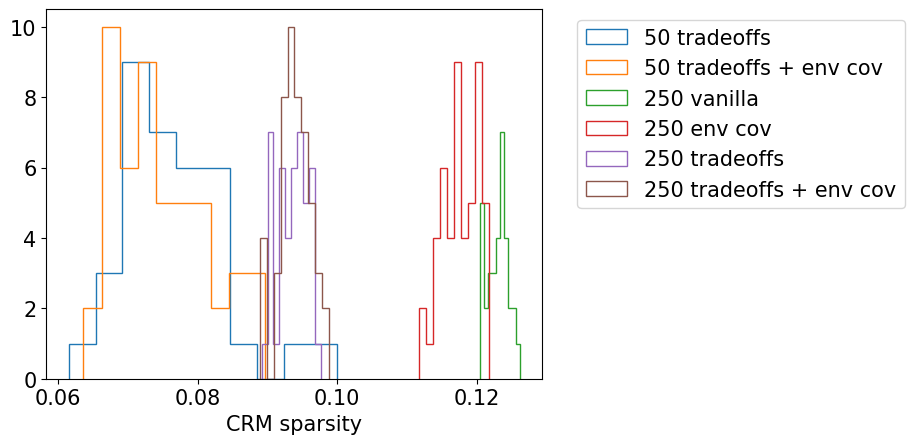

Crm sparsity
-------------------  ----------------------  -------------------  -------------------  -------------------  -----------------------
50 tradeoffs         50 tradeoffs + env cov  250 vanilla          250 env cov          250 tradeoffs        250 tradeoffs + env cov
0.07647181830668635  0.07492262992826619     0.12301822558016065  0.11757201720934855  0.09360296455484907  0.09399724825568022
-------------------  ----------------------  -------------------  -------------------  -------------------  -----------------------


In [78]:
table_data = []
for df, df_key in zip([df_50_vanilla, df_50_env_trade, df_250_vanilla, df_250_env_trade, df_250_bac_trade, df_250_env_bac_trade], 
                        ['50 tradeoffs', '50 tradeoffs + env cov', '250 vanilla', '250 env cov', '250 tradeoffs', 
                        '250 tradeoffs + env cov']):
    output = df['crm_sparsity'].mean()
    # spearman, pval = output['r'].values[0], output['p-val'].values[0]
    # print(pval)
    # if pval > 0.05:
    #     spearman = np.nan
    table_data.append([df_key, output])
    
    plt.hist(df['crm_sparsity'], histtype='step', label=df_key)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('CRM sparsity')
# plt.yscale('log')
plt.show()
table_data = np.array(table_data).T
# print('###################################')
print(f'Crm sparsity')
print(tabulate(table_data))

### Env dim vs Niche dim

In [4]:
print('####################################################')
print("ENV DIM LOG\n")
print('50 tradeoffs')
results = pg.partial_corr(df_50_vanilla, x='NicheDim', y = 'EnvDimLog', method='spearman')
print(f'Spearman: {results['r'].values[0]:.2f}, P-val: {results['p-val'].values[0]}\n')

print('50 tradeoffs + env cov')
results = pg.partial_corr(df_50_env_trade, x='NicheDim', y = 'EnvDimLog', method='spearman')
print(f'Spearman: {results['r'].values[0]:.2f}, P-val: {results['p-val'].values[0]}\n')

print('250')
results = pg.partial_corr(df_250_vanilla, x='NicheDim', y = 'EnvDimLog', method='spearman')
print(f'Spearman: {results['r'].values[0]:.2f}, P-val: {results['p-val'].values[0]}\n')

print('250 tradeoffs')
results = pg.partial_corr(df_250_bac_trade, x='NicheDim', y = 'EnvDimLog', method='spearman')
print(f'Spearman: {results['r'].values[0]:.2f}, P-val: {results['p-val'].values[0]}\n')

print('250 env cov')
results = pg.partial_corr(df_250_env_trade, x='NicheDim', y = 'EnvDimLog', method='spearman')
print(f'Spearman: {results['r'].values[0]:.2f}, P-val: {results['p-val'].values[0]}\n')

print('250 tradeoffs + env cov')
results = pg.partial_corr(df_250_env_bac_trade, x='NicheDim', y = 'EnvDimLog', method='spearman')
print(f'Spearman: {results['r'].values[0]:.2f}, P-val: {results['p-val'].values[0]}\n')

####################################################
ENV DIM LOG

50 tradeoffs
Spearman: 0.12, P-val: 0.47656955457622474

50 tradeoffs + env cov
Spearman: 0.38, P-val: 8.837258234588932e-08

250
Spearman: 0.00, P-val: 0.9852723280032907

250 tradeoffs
Spearman: 0.07, P-val: 0.6481089768854542

250 env cov
Spearman: 0.44, P-val: 3.789238973675273e-08

250 tradeoffs + env cov
Spearman: 0.29, P-val: 1.819010724416727e-05



In [10]:
results['r'].values[0]

0.2897393301956064

In [5]:


def plot_ND_vs_env_dim(df, k=10, x_label= 'EnvDimLog', label="", color='CO', linestyle='--'):
    """
    Bins the continuous x_label (x) values into k bins, 
    calculates the mean and standard error of the mean (SEM) for both 
    x_label (x) and 'NicheDim' (y) for each bin, and plots the results 
    with error bars in both axes.

    Args:
        df (pd.DataFrame): DataFrame containing x_label and 'NicheDim' columns.
        k (int): The number of equal-width bins to create for x_label.
    """
    # 1. Create a clean copy to resolve SettingWithCopyWarning
    df_copy = df[[x_label, 'NicheDim']].copy()

    # 2. Binning the continuous x_label variable
    df_copy['EnvDim_Bin'] = pd.cut(df_copy[x_label], bins=k, include_lowest=True)
    
    # 3. Data Aggregation (Statistics per Bin)
    summary_df = df_copy.groupby('EnvDim_Bin', observed=True).agg(
        # Y-axis (NicheDim) statistics
        y_mean=('NicheDim', 'mean'),
        # Return NaN for SEM if N <= 1 to resolve RuntimeWarning
        y_sem=('NicheDim', lambda x: sp.stats.sem(x) if len(x) > 1 else np.nan),
        # X-axis (EnvPrLogCorr) statistics - SEM of the x-values within the bin
        x_sem=(x_label, lambda x: sp.stats.sem(x) if len(x) > 1 else np.nan),
    ).reset_index()

    # 4. Calculate Bin Centers for Plotting (X-Axis)
    summary_df['x_plot'] = summary_df['EnvDim_Bin'].apply(lambda x: x.mid)

    # Filter out bins where SEM calculation failed (N <= 1)
    summary_df.dropna(subset=['y_sem', 'x_sem'], inplace=True)

    # Get values for plotting
    x_plot = summary_df['x_plot'].values
    y_plot = summary_df['y_mean'].values
    y_err = summary_df['y_sem'].values
    x_err = summary_df['x_sem'].values # The calculated x-axis error
    
    # Plot with error bars in both axes (xerr and yerr)
    plt.errorbar(
        x_plot, 
        y_plot, 
        yerr=y_err/2, 
        xerr=x_err/2, 
        fmt='o', 
        capsize=5, 
        color=color
    )
    plt.plot(x_plot, y_plot, color=color, 
        label=label, linestyle=linestyle)
    # print('X values:', x_plot)
    # print('Y values:',y_plot)
    
def plot_ND_vs_env_dim_contour(df, x_label='EnvDimLog', label="", cmap='viridis', fill=False):
    """
    Generates a 2D kernel density estimation (KDE) contour plot
    showing the joint distribution of a continuous variable (x_label) 
    and 'NicheDim' (Y-axis).

    This plot visualizes the density of data points across the plane,
    where denser areas (often shown with brighter colors or closer contours)
    indicate more frequent combinations of the two variables.

    Args:
        df (pd.DataFrame): DataFrame containing x_label and 'NicheDim' columns.
        x_label (str): The column name for the X-axis (e.g., 'EnvDimLog').
        title (str): The title for the generated plot.
        cmap (str): The colormap to use for the density shading.
        fill (bool): If True, fill the areas under the contours (creates a heatmap effect).
    """
    
    # 1. Input Validation and Data Extraction
    if x_label not in df.columns or 'NicheDim' not in df.columns:
        print(f"Error: DataFrame must contain both '{x_label}' and 'NicheDim' columns.")
        return

    # Extract the two columns of interest
    x_data = df[x_label]
    y_data = df['NicheDim']

    # 2. Setup the Plotting Environment
    # Set a custom style for better visual appeal
    # sns.set_theme(style="whitegrid")
    
    # plt.figure(figsize=(10, 8))

    # 3. Generate the 2D KDE Contour Plot
    # We use seaborn's kdeplot for generating the 2D density estimate.
    # The contours visually represent the probability density function.
    sns.kdeplot(
        x=x_data,
        y=y_data,
        cmap=cmap,  # Color map (e.g., 'viridis', 'magma', 'Reds')
        fill=fill,  # Fill the space under the contours
        # levels=10,  # Number of contour lines/levels (default is fine)
        # cbar=True, # Optional: Add a color bar
        linewidths=0.5 if fill else 1.5, # Thinner lines if filling
    )
    
    # Optional: Add the scatter points of the raw data (use alpha for transparency)
    # This helps see the actual distribution underlying the contours.
    plt.scatter(x_data, y_data, s=10, alpha=0.3, color='black', label=label)

    # 4. Set Labels and Title
    # plt.xlabel(f'Log Environment Dimension ({x_label})')
    # plt.ylabel('Niche Dimension')
    # plt.title(title, fontsize=14)
    
    # # Add a legend for the scatter points
    # plt.legend()
    
    # 5. Display the Plot
    # plt.show()

In [ ]:
output_file = '/home/ks2823/Microbiomap/Data/Borenstein_all_env.json'
with open(output_file, 'r') as f:
    read_data = json.load(f)

cg_all = np.array(read_data['NicheDim'])
svd_all = np.array(read_data['EnvDim'])
labels = np.array(read_data['label'])

cross_sectional_labels = [
    'ERAWIJANTARI_GASTRIC_CANCER_2020_Gastrectomy',
    'ERAWIJANTARI_GASTRIC_CANCER_2020_Healthy', 
    'FRANZOSA_IBD_2019_CD',
    'FRANZOSA_IBD_2019_Control', 
    'FRANZOSA_IBD_2019_UC',
    # 'HE_INFANTS_MFGM_2019_Baseline', 
    # 'HE_INFANTS_MFGM_2019_Month12',
    # 'HE_INFANTS_MFGM_2019_With.comp.food',
    # 'HE_INFANTS_MFGM_2019_Without.comp.food',
    'JACOBS_IBD_FAMILIES_2016_CD', 
    'JACOBS_IBD_FAMILIES_2016_Normal',
    'JACOBS_IBD_FAMILIES_2016_UC', 
    'KANG_AUTISM_2017_Autistic ',
    'KANG_AUTISM_2017_Neurotypical', 
    'KIM_ADENOMAS_2020_Adenoma',
    'KIM_ADENOMAS_2020_Carcinoma', 
    'KIM_ADENOMAS_2020_Control',
    'SINHA_CRC_2016_0', 
    'SINHA_CRC_2016_1', 
    'WANG_ESRD_2020_Control',
    'WANG_ESRD_2020_ESRD', 
    'YACHIDA_CRC_2019_HS',
    'YACHIDA_CRC_2019_Healthy', 
    'YACHIDA_CRC_2019_MP',
    'YACHIDA_CRC_2019_Stage_0', 
    'YACHIDA_CRC_2019_Stage_III_IV',
    'YACHIDA_CRC_2019_Stage_I_II',
]

mask = np.isin(labels, cross_sectional_labels)

x = cg_all
y = svd_all

x = x[mask]
y = y[mask]

/gpfs/gibbs/project/p_dixit/ks2823/conda_envs/CGM/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


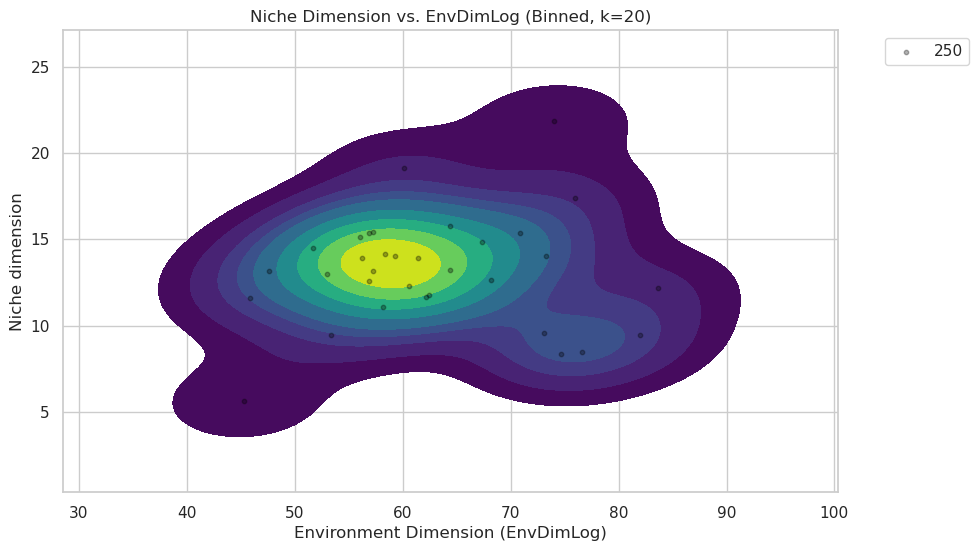

In [13]:
# 4. Plotting
plt.figure(figsize=(10, 6))

X_LABEL = 'EnvDimLog'
K = 20
# plt.scatter(y, x, label='Borenstein', color='black')
plot_ND_vs_env_dim_contour(df_250_vanilla, label='250')

# plot_ND_vs_env_dim(df_50_vanilla, k=K, label='50 tradeoffs', color='indianred', linestyle='-.')
# plot_ND_vs_env_dim(df_250_bac_trade, k=K, label='250 tradeoffs', color='darkorange', linestyle='-.')

# plot_ND_vs_env_dim(df_250_env_trade, k=K, label='250 env cov', color='blue', linestyle='--')

# plot_ND_vs_env_dim(df_50_env_trade, k=K, label='50 tradeoffs + env cov', color='red', linestyle='-')
# plot_ND_vs_env_dim(df_250_env_bac_trade, k=K, label='250 tradeoffs + env cov', color='green', linestyle='-')


# # 5. Labels and Title"
plt.xlabel(f'Environment Dimension ({X_LABEL})')
plt.ylabel('Niche dimension')
plt.title(f'Niche Dimension vs. {X_LABEL} (Binned, k={K})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.xscale('log')
# plt.yscale('log')
plt.show()

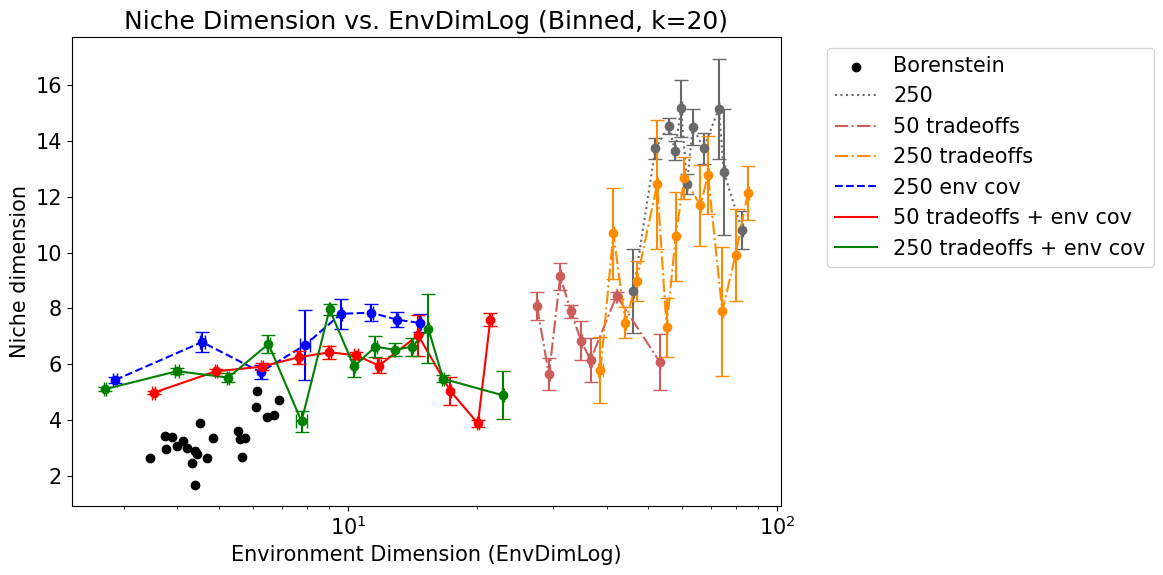

In [ ]:
# 4. Plotting
plt.figure(figsize=(12, 6))

X_LABEL = 'EnvDimLog'
K = 20
plt.scatter(y, x, label='Borenstein', color='black')
plot_ND_vs_env_dim(df_250_vanilla, k=K, label='250', color='dimgray', linestyle=':')

plot_ND_vs_env_dim(df_50_vanilla, k=K, label='50 tradeoffs', color='indianred', linestyle='-.')
plot_ND_vs_env_dim(df_250_bac_trade, k=K, label='250 tradeoffs', color='darkorange', linestyle='-.')

plot_ND_vs_env_dim(df_250_env_trade, k=K, label='250 env cov', color='blue', linestyle='--')

plot_ND_vs_env_dim(df_50_env_trade, k=K, label='50 tradeoffs + env cov', color='red', linestyle='-')
plot_ND_vs_env_dim(df_250_env_bac_trade, k=K, label='250 tradeoffs + env cov', color='green', linestyle='-')


# # 5. Labels and Title"
plt.xlabel(f'Environment Dimension ({X_LABEL})')
plt.ylabel('Niche dimension')
plt.title(f'Niche Dimension vs. {X_LABEL} (Binned, k={K})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(False, linestyle='--', alpha=0.6)
plt.xscale('log')
# plt.yscale('log')
plt.tight_layout()
plt.savefig('/home/ks2823/Microbiomap/Pictures/NicheDim_EnvDimLog_IS_borenstein.pdf', format='pdf')
plt.show()

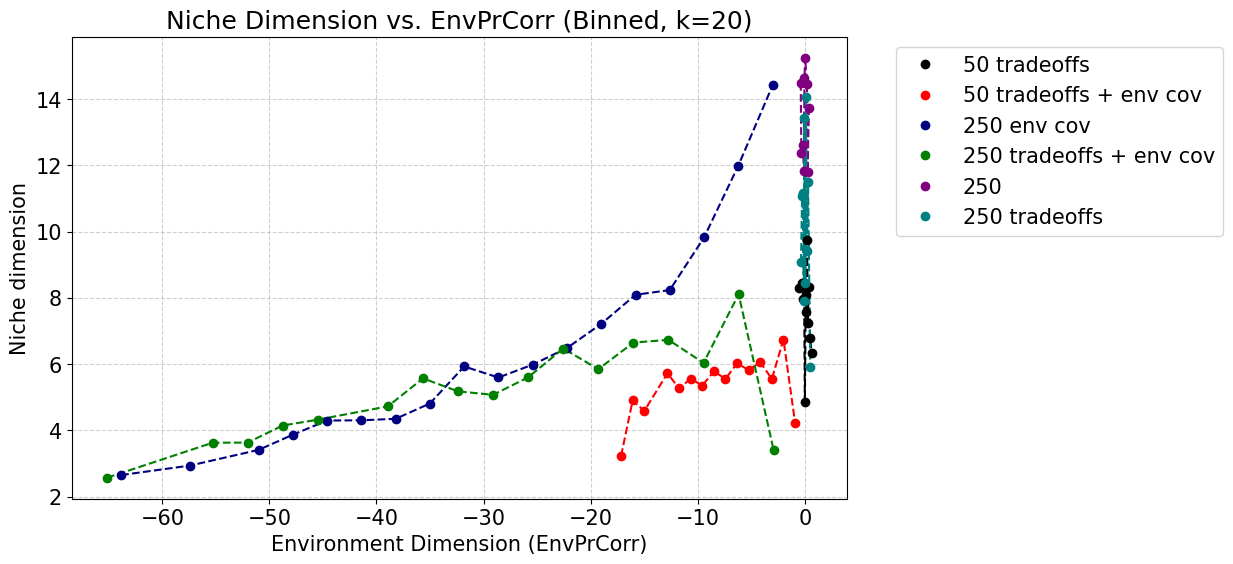

In [15]:
# 4. Plotting
plt.figure(figsize=(10, 6))
X_LABEL = 'EnvPrCorr'

K = 20
plot_ND_vs_env_dim(df_50_vanilla, x_label=X_LABEL, k=K, label='50 tradeoffs', color='black')
plot_ND_vs_env_dim(df_50_env_trade, x_label=X_LABEL, k=K, label='50 tradeoffs + env cov', color='red')
plot_ND_vs_env_dim(df_250_env_trade, x_label=X_LABEL, k=K, label='250 env cov', color='navy')
plot_ND_vs_env_dim(df_250_env_bac_trade, x_label=X_LABEL, k=K, label='250 tradeoffs + env cov', color='green')
plot_ND_vs_env_dim(df_250_vanilla, x_label=X_LABEL, k=K, label='250', color='purple')
plot_ND_vs_env_dim(df_250_bac_trade, x_label=X_LABEL, k=K, label='250 tradeoffs', color='teal')

# # 5. Labels and Title"
plt.xlabel(f'Environment Dimension ({X_LABEL})')
plt.ylabel('Niche dimension')
plt.title(f'Niche Dimension vs. {X_LABEL} (Binned, k={K})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

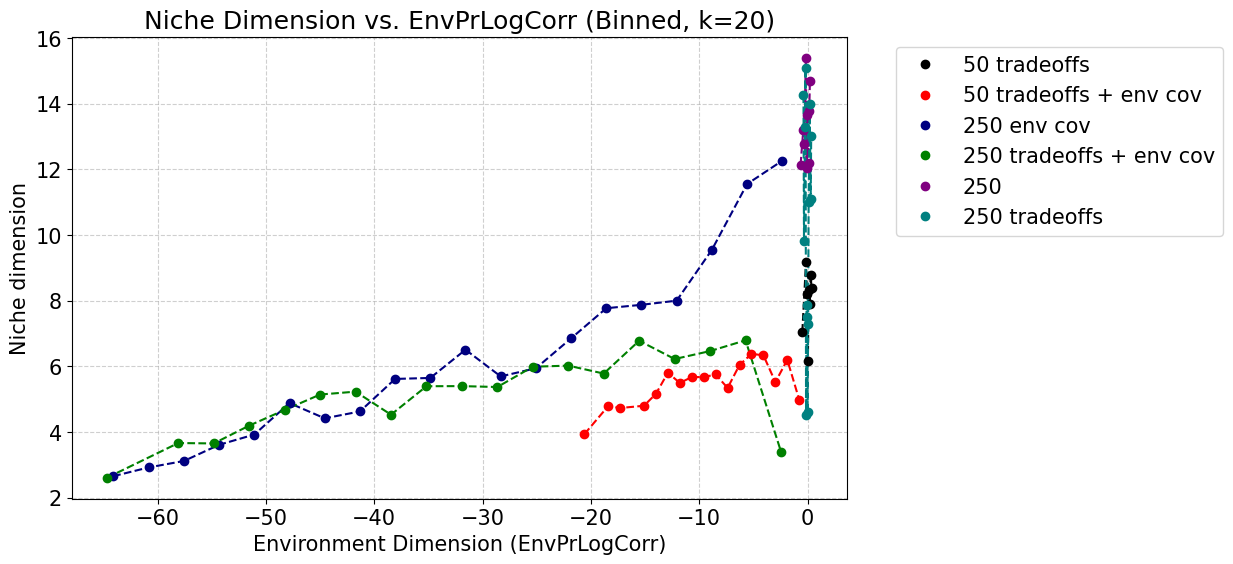

In [16]:
# 4. Plotting
plt.figure(figsize=(10, 6))
X_LABEL = 'EnvPrLogCorr'

K = 20
plot_ND_vs_env_dim(df_50_vanilla, x_label=X_LABEL, k=K, label='50 tradeoffs', color='black')
plot_ND_vs_env_dim(df_50_env_trade, x_label=X_LABEL, k=K, label='50 tradeoffs + env cov', color='red')
plot_ND_vs_env_dim(df_250_env_trade, x_label=X_LABEL, k=K, label='250 env cov', color='navy')
plot_ND_vs_env_dim(df_250_env_bac_trade, x_label=X_LABEL, k=K, label='250 tradeoffs + env cov', color='green')
plot_ND_vs_env_dim(df_250_vanilla, x_label=X_LABEL, k=K, label='250', color='purple')
plot_ND_vs_env_dim(df_250_bac_trade, x_label=X_LABEL, k=K, label='250 tradeoffs', color='teal')

# # 5. Labels and Title"
plt.xlabel(f'Environment Dimension ({X_LABEL})')
plt.ylabel('Niche dimension')
plt.title(f'Niche Dimension vs. {X_LABEL} (Binned, k={K})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Competition

Spearman: -0.71, P-value: 2.9954754791563848e-06


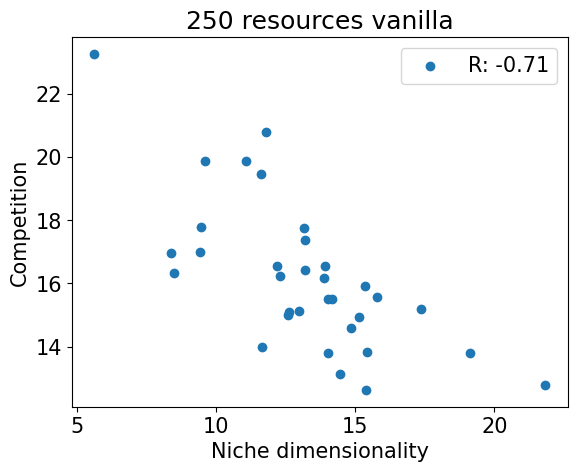

In [13]:
x = df_250_vanilla['NicheDim']
y = df_250_vanilla['comp']

spearman, pval = sp.stats.spearmanr(x, y)
print(f"Spearman: {spearman:.2f}, P-value: {pval}")

plt.scatter(x, y, label=f'R: {spearman:.2f}')
plt.xlabel('Niche dimensionality')
plt.ylabel('Competition')
plt.title('250 resources vanilla')
plt.legend()
plt.show()

Spearman: -0.37, P-value: 6.170572472298093e-06


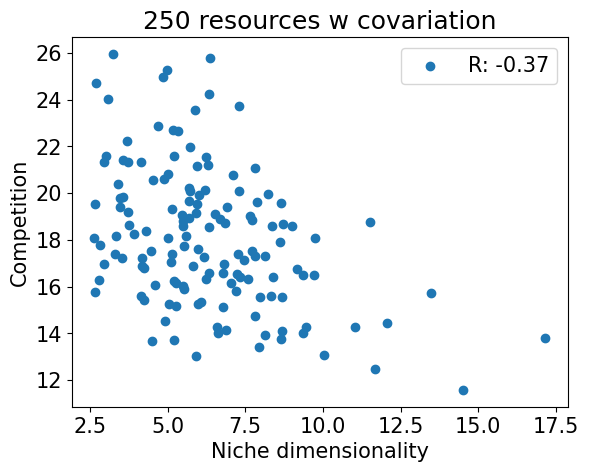

In [16]:
x = df_250_env_trade['NicheDim']
y = df_250_env_trade['comp']

spearman, pval = sp.stats.spearmanr(x, y)
print(f"Spearman: {spearman:.2f}, P-value: {pval}")

plt.scatter(x, y, label=f'R: {spearman:.2f}')
plt.xlabel('Niche dimensionality')
plt.ylabel('Competition')
plt.title('250 resources w covariation')
plt.legend()
plt.show()